In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter

In [2]:
data_file_path = 'train.txt'
data = pd.read_csv(data_file_path, sep='\t', header=None, names=['label', 'text'])
data['text'] = data['text'].astype(str)
print(data.head())

               label                                               text
0   TRUTHFULPOSITIVE  The sheraton was a wonderful hotel! When me an...
1   TRUTHFULPOSITIVE  We stayed at the Omni between Christmas and Ne...
2  DECEPTIVENEGATIVE  I was REALLY looking forward to a nice relaxin...
3   TRUTHFULNEGATIVE  First let me say, I try not to be too critical...
4  DECEPTIVENEGATIVE  The Ambassador East Hotel is a terrible place ...


In [64]:
reviews = data['text']
labels = data['label']

# simple preprocessing
reviews = reviews.str.lower()
reviews = reviews.str.replace(r'[^\w\s]', '', regex=True)

# splitting into train, validation, test data
X_train, X_val, y_train, y_val = train_test_split(reviews, labels, test_size=0.2, random_state=42)

In [78]:
# TF-ID vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print(tfidf_vectorizer.stop_words_)

set()


# Support Vector classifier

                   precision    recall  f1-score   support

DECEPTIVENEGATIVE       0.88      0.88      0.88        69
DECEPTIVEPOSITIVE       0.72      0.89      0.80        56
 TRUTHFULNEGATIVE       0.84      0.87      0.86        71
 TRUTHFULPOSITIVE       0.90      0.73      0.80        84

         accuracy                           0.84       280
        macro avg       0.84      0.84      0.84       280
     weighted avg       0.84      0.84      0.84       280



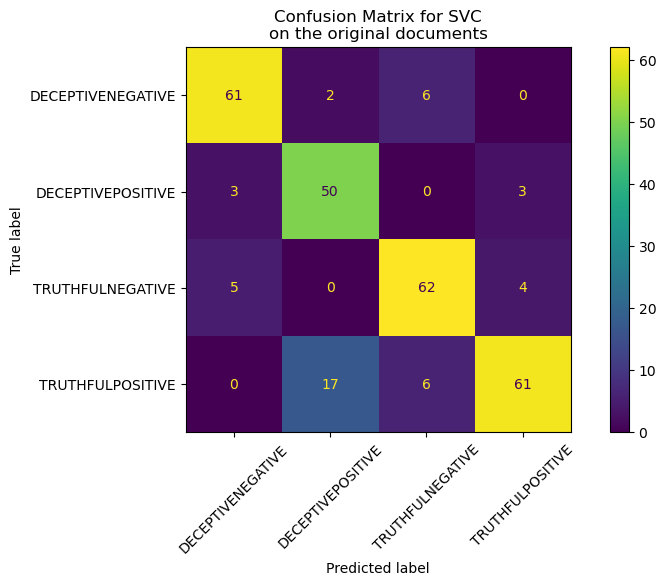

In [79]:
svm_classifier = SVC()

param_grid = {
    'C': [2,3,4],
    'gamma': [.4, .45, .5],  # For RBF kernel
}

grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, scoring='accuracy')

grid_search.fit(X_train_tfidf, y_train)

best_params = grid_search.best_params_
best_svm_classifier = grid_search.best_estimator_

y_val_pred = best_svm_classifier.predict(X_val_tfidf)

print(classification_report(y_val, y_val_pred))

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, ax=ax)
plt.xticks(rotation = 45)
_ = ax.set_title(
    f"Confusion Matrix for {svm_classifier.__class__.__name__}\non the original documents"
)

In [67]:
grid_search.best_params_

{'C': 3, 'gamma': 0.5}

In [81]:
negative_deceptive = list()
negative_truthful = list()
positive_deceptive = list()
positive_truthful = list()
truthful_negative = list()
truthful_positive = list()
deceptive_negative = list()
deceptive_positive =list()

for row_index, (input, prediction, label) in enumerate(zip (X_val_tfidf, y_val_pred, y_val)):
  if prediction != label:
    print('Row', row_index, 'has been classified as ', prediction, 'and should be ', label)
    if prediction == "DECEPTIVENEGATIVE" and label=="TRUTHFULNEGATIVE":
        negative_deceptive.append(row_index)
    elif prediction == "TRUTHFULNEGATIVE" and label=="DECEPTIVENEGATIVE":
        negative_truthful.append(row_index)
    elif prediction == "DECEPTIVEPOSITIVE" and label=="TRUTHFULPOSITIVE":
        positive_deceptive.append(row_index)
    elif prediction == "TRUTHFULPOSITIVE" and label=="DECEPTIVEPOSITIVE":
        positive_truthful.append(row_index)
    elif prediction == "TRUTHFULNEGATIVE" and label=="TRUTHFULPOSITIVE":
        truthful_negative.append(row_index)
    elif prediction == "TRUTHFULPOSITIVE" and label=="TRUTHFULNEGATIVE":
        truthful_positive.append(row_index)
    elif prediction == "DECEPTIVENEGATIVE" and label=="DECEPTIVEPOSITIVE":
        deceptive_negative.append(row_index)
    elif prediction == "DECEPTIVEPOSITIVE" and label=="DECEPTIVENEGATIVE":
        deceptive_positive.append(row_index)
    
    

Row 2 has been classified as  TRUTHFULPOSITIVE and should be  TRUTHFULNEGATIVE
Row 12 has been classified as  DECEPTIVEPOSITIVE and should be  TRUTHFULPOSITIVE
Row 17 has been classified as  TRUTHFULNEGATIVE and should be  DECEPTIVENEGATIVE
Row 24 has been classified as  TRUTHFULNEGATIVE and should be  TRUTHFULPOSITIVE
Row 31 has been classified as  TRUTHFULNEGATIVE and should be  DECEPTIVENEGATIVE
Row 42 has been classified as  TRUTHFULNEGATIVE and should be  TRUTHFULPOSITIVE
Row 43 has been classified as  TRUTHFULNEGATIVE and should be  TRUTHFULPOSITIVE
Row 51 has been classified as  DECEPTIVEPOSITIVE and should be  TRUTHFULPOSITIVE
Row 52 has been classified as  DECEPTIVEPOSITIVE and should be  DECEPTIVENEGATIVE
Row 55 has been classified as  DECEPTIVEPOSITIVE and should be  TRUTHFULPOSITIVE
Row 57 has been classified as  DECEPTIVENEGATIVE and should be  TRUTHFULNEGATIVE
Row 62 has been classified as  TRUTHFULPOSITIVE and should be  TRUTHFULNEGATIVE
Row 69 has been classified as  DE

In [122]:
print("Checking the individual sentences:\n")
for x in deceptive_positive:
    words=X_val.iloc[x].split()
    words = set(words)
    words = words - ENGLISH_STOP_WORDS
    print(X_val.iloc[x])
    print(words)

Checking the individual sentences:

i stayed at the monacochicago back in april i was in town on business and the hotel was recommended by a friend of mine having spent a weekend there i have no idea what my friend was talking about the complimentary morning coffee was weak the fitness room was dimly lit and i thought id have to have my clothes mailed back to me when i used their supposed overnight laundry service for a suit i spilled some wine on my room was adequate but nowhere near what ive seen elsewhere at this price point recent renovation must be slang for everything is stiff and smells of industrial adhesive the mattress in my room was incredibly firm and i slept poorly when i travel i expect an experience similar to or better than my experience at home at most hotels i receive excellent service and comfortable accomodations this was an exception to my usual and i wont be back anytime soon
{'industrial', 'service', 'stayed', 'incredibly', 'coffee', 'having', 'april', 'travel', 

In [120]:
test_file_path = 'test_just_reviews.txt'
test_df = pd.read_csv(test_file_path, sep='\t', header=None, names=['text'])
test_df['text'] = test_df['text'].astype(str)

test_reviews = test_df['text']

# simple preprocessing
test_reviews = test_reviews.str.lower()
test_reviews = test_reviews.str.replace(r'[^\w\s]', '', regex=True)

test_reviews_tfidf = tfidf_vectorizer.transform(test_reviews)

test_pred = best_svm_classifier.predict(test_reviews_tfidf)
df_test_pred=pd.DataFrame(test_pred)
df_test_pred[0].to_csv('results.txt',header=None,index=False)